In [1]:
import sys
import os
#import torch
import zarr
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#from torch import nn
from pathlib import Path
from scipy.stats import linregress

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data, udomains, datapath
from Medley.utils import data_for_pcolormesh
from Medley.analysis import trendfit_robust

In [63]:
def plot_stations(stat: pd.Series, statloc: pd.DataFrame, fig = None, ax = None, cbar = True, scatter_kwargs = {}):
    try:
        s = scatter_kwargs.pop('s')
    except KeyError:
        s = 20
    if (fig is None):
        fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    lats = statloc.loc[stat.index,'LAT'].values
    lons = statloc.loc[stat.index,'LON'].values
    im = ax.scatter(x = lons, y = lats, c = stat.values, s= s, transform = ccrs.PlateCarree(), **scatter_kwargs)
    if cbar:
        fig.colorbar(im, ax = ax, shrink = 0.8)
    return fig, ax, im

def plot_plus_stations(da: xr.DataArray, stat: pd.Series = None, statloc: pd.DataFrame = None,
                       fig = None, ax = None, pcmesh_kwargs = {}, cbar = True, scatter_kwargs = {}):
    shading = 'flat'
    try:
        vmin = pcmesh_kwargs.pop('vmin')
    except KeyError:
        vmin = float(da.quantile(0.02))
    try:
        vmax = pcmesh_kwargs.pop('vmax')
    except KeyError:
        vmax = float(da.quantile(0.98))
    if (fig is None):
        fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    im = ax.pcolormesh(*data_for_pcolormesh(da, shading = shading), shading = shading, transform = ccrs.PlateCarree(),
                  vmin = vmin, vmax = vmax, **pcmesh_kwargs)
    if not (stat is None):
        scatter_kwargs.update(dict(vmin = vmin, vmax = vmax, cmap = im.cmap))
        fig, ax, _ = plot_stations(stat = stat, statloc = statloc, fig = fig, ax = ax, cbar = False, scatter_kwargs = scatter_kwargs)
    if cbar:
        fig.colorbar(im, ax = ax, shrink = 0.8)
    return fig, ax, im

## Data loading

In [3]:
rr_eobs = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v27.0e.zarr/')['rr'].compute()

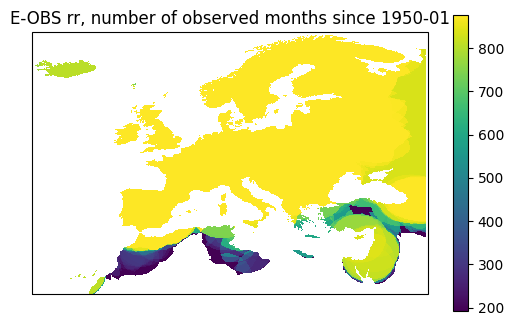

In [32]:
#test = pd.Series([90,10,50],index = [21,26074,11383])
da = rr_eobs.count('time')
da = xr.where(da == 0, np.nan, da)
#fig, ax = plot_plus_stations(da = da, stat = test, statloc = rr_ecad_locs, pcmeshkwargs={'vmin': 10,'vmax':100})
fig, ax, im = plot_plus_stations(da = da)
ax.set_title('E-OBS rr, number of observed months since 1950-01')
plt.show()

In [5]:
window = 30 # Monthly accumulation
wsd = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/1979_2021_monthly_water_surplus_deficit.zarr/')[f'spei_{window}']
lsmask = xr.open_dataarray('/scistor/ivm/jsn295/Medi/landseamask_wp3.nc')
wsd = xr.where(lsmask, wsd, np.nan).compute() # Landsea masking

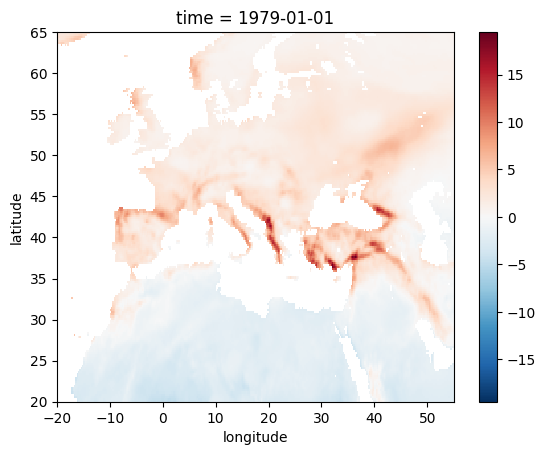

In [6]:
wsd[:,:,0].plot()

In [66]:
rr_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_RR.h5')
rr_ecad.index.name = 'time'
rr_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_RR_stations.h5')

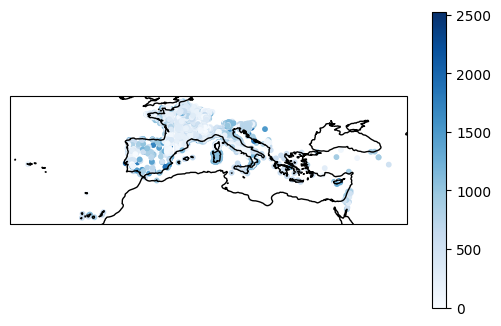

In [53]:
#fig, ax = plot_stations(rr_ecad.max(), rr_ecad_locs, scatter_kwargs=dict(vmin = 0, vmax = 600, cmap = 'Blues'))
fig, ax, im = plot_stations(rr_ecad.count(), rr_ecad_locs, scatter_kwargs=dict(cmap = 'Blues', s = 10))
ax.coastlines()
plt.show()

### Trend in monthly precipitation sums, per season.

In [39]:
min_count = 100
rr_ecad_1950 = rr_ecad.loc[slice('1950',None),:].stack().to_xarray()
rr_ecad_1950.attrs['units'] = 'mm'

In [41]:
datas = {'eobs':rr_eobs,'ecad':rr_ecad_1950}
seasonal_trends = {'eobs':{},'ecad':{}}
for name, data in datas.items():
    for season in np.unique(data.time.dt.season):
        subset = data.isel(time = (data.time.dt.season == season))
        seasonal_trends[name].update({season:trendfit_robust(subset, standardize=False, min_count = min_count)})
    seasonal_trends[name] = xr.Dataset(seasonal_trends[name])

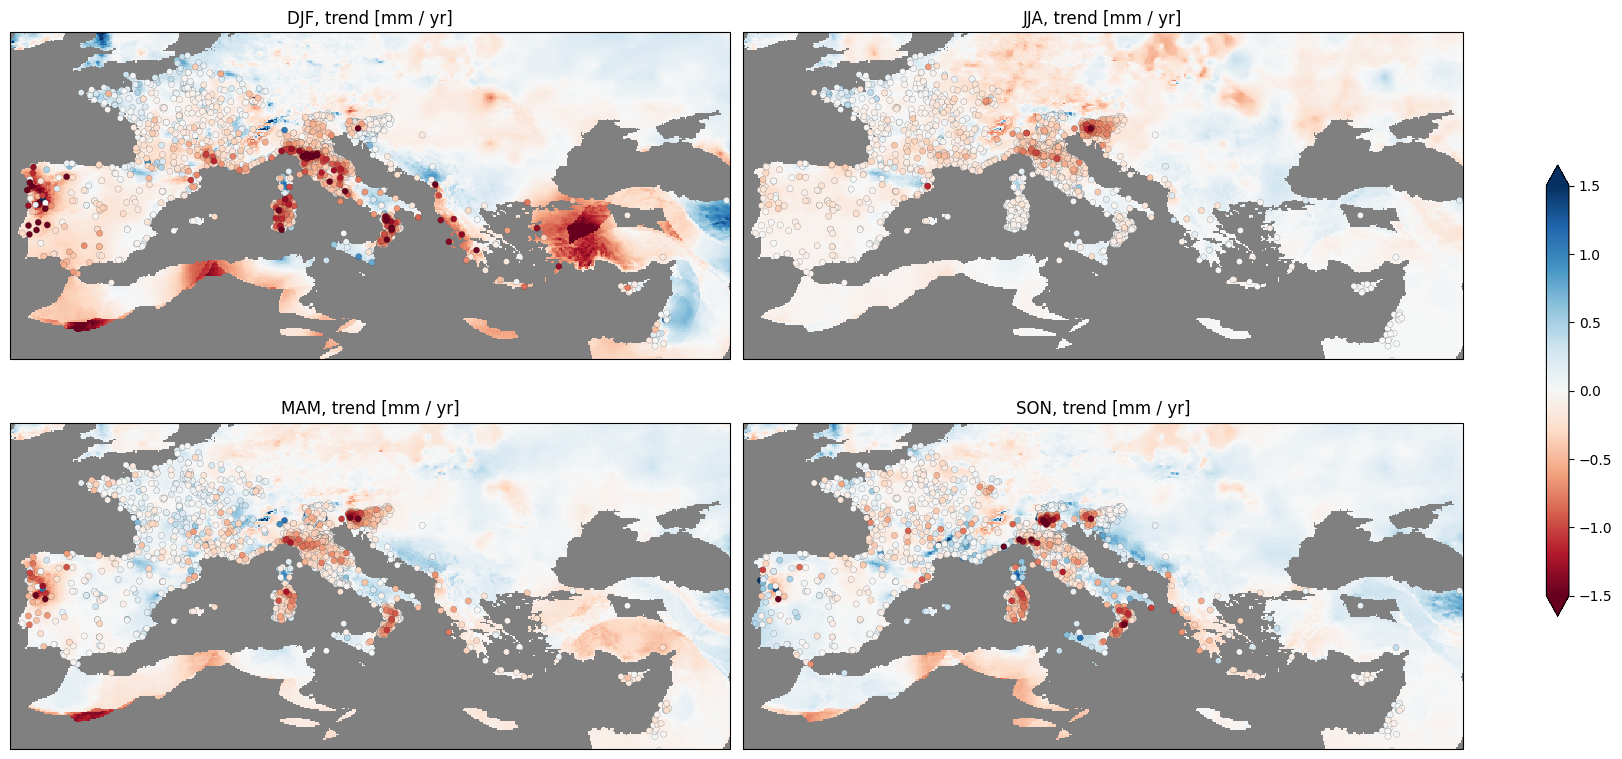

In [87]:
vmin, vmax = -1.5, 1.5
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (17,8), subplot_kw={'projection':ccrs.PlateCarree()})
for i, season in enumerate(np.unique(rr_eobs.time.dt.season)):
    ax = axes[i//2,i%2]
    ax.set_facecolor('grey')
    da = seasonal_trends['eobs'][season].sel(what = 'slope')
    stations = seasonal_trends['ecad'][season].sel(what = 'slope').to_pandas()
    stations = stations.dropna().sort_values(ascending = False)
    fig, ax, im = plot_plus_stations(da = da, stat = stations, statloc=rr_ecad_locs, fig = fig, ax = ax, 
                                   pcmesh_kwargs=dict(vmin = vmin, vmax = vmax, cmap = cmap), cbar= False,
                                    # scatter_kwargs={'s':10})
                                    scatter_kwargs={'s':20,'edgecolors':'black','linewidths':0.1})
    ax.set_title(f'{season}, trend [mm / yr]')
    ax.set_extent((-10,40,30,50))
plt.tight_layout()
cbar = fig.colorbar(im, ax = axes, extend = 'both', fraction = 0.08, shrink = 0.6)

In [91]:
# Per quarter, accumulated precip
seasonal_trend = {}
quarters = {1:'JFM',2:'AMJ',3:'JAS',4:'OND'}
accumulated = rrmon.resample(time = 'QS').sum(skipna = False).compute() # CHanges temporal chunking so compute
for quarter in quarters.keys():
    subset = accumulated.isel(time = (accumulated.time.dt.quarter == quarter))
    seasonal_trend.update({quarters[quarter]:compute_trends(subset)})
seasonal_trend = xr.Dataset(seasonal_trend)

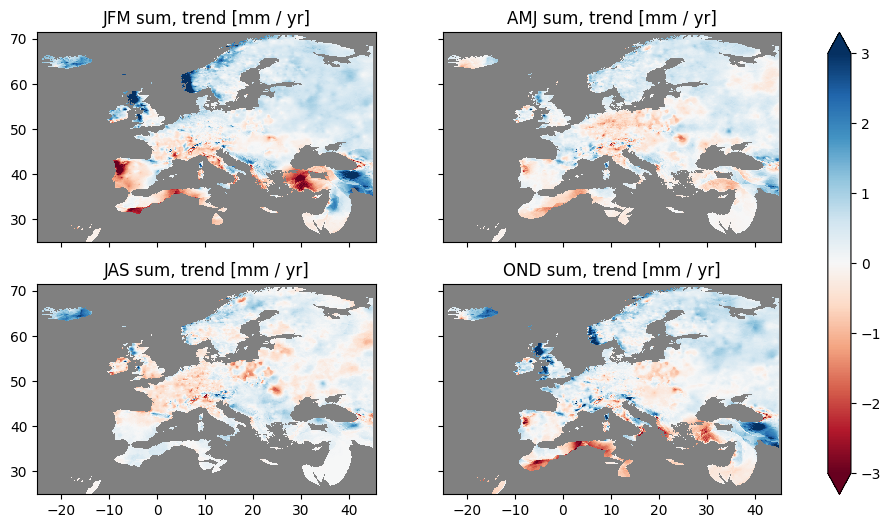

In [94]:
vmin, vmax = -3, 3
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (12,6))
for i, season in enumerate(quarters.values()):
    ax = axes[i//2,i%2]
    ax.set_facecolor('grey')
    im = ax.pcolormesh(*data_for_pcolormesh(seasonal_trend[season].sel(what = 'slope'), shading = 'flat'), cmap = cmap, vmin = vmin, vmax = vmax)
    ax.set_title(f'{season} sum, trend [mm / yr]')
cbar = fig.colorbar(im, ax = axes, extend = 'both')

In [130]:
# Potential non-linearity in the trends
locs = {
    'North_of_Portugal':(41.2,-8.5),
    'North_of_Italy':(45,11),
    'Israel':(32.1,35),
    'West_of_Turkey':(39.6,27.7),
    'East_of_Turkey':(40.1,41.1),
}
window_length = 20

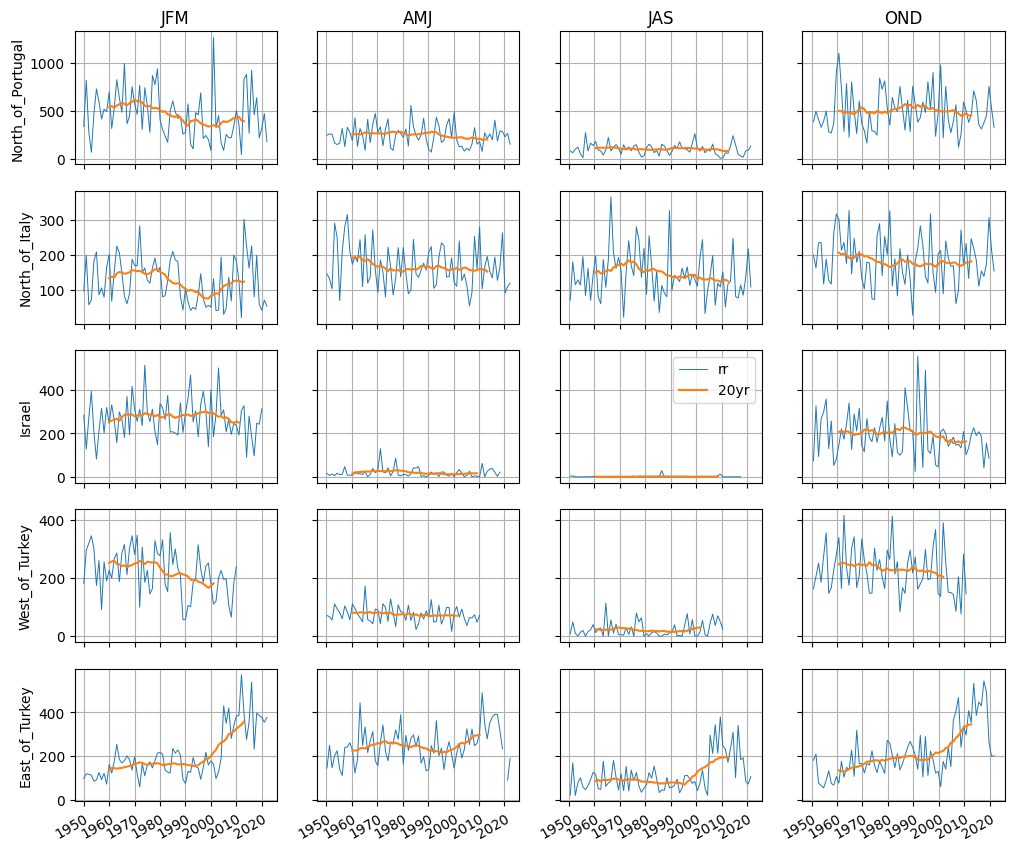

In [135]:
fig, axes = plt.subplots(nrows = len(locs), ncols = len(quarters), figsize = (12,10), sharex = True, sharey = 'row')
for i, (name, (lat,lon)) in enumerate(locs.items()):
    for j, (quarter, season) in enumerate(quarters.items()):
        ax = axes[i,j]
        if i == 0:
            ax.set_title(season)
        if j == 0:
            ax.set_ylabel(name)
        series = accumulated.sel(latitude = lat, longitude = lon, method = 'nearest').isel(time = (accumulated.time.dt.quarter == quarter))
        avg = series.rolling(time = window_length, center=True).mean()
        ax.plot(series.time, series.values, label = 'rr', lw = 0.7)
        ax.plot(avg.time, avg.values, label = f'{window_length}yr')
        if (i == 2) and (j == 2):
            ax.legend()
        ax.grid()
        if i == (len(locs) -1):
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
plt.show()

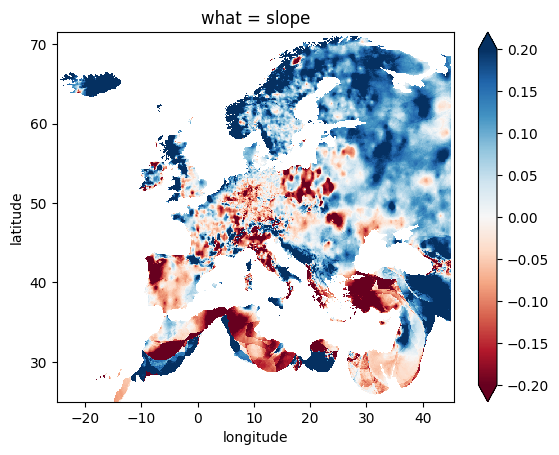

In [137]:
yearround_trend.sel(what = 'slope').plot(vmin = -0.2, vmax = 0.2, cmap = cmap)

In [140]:
spimon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/spi3_mon_0.1deg_reg_ens_median_E-OBSv23.1e.zarr/')['spi3ETCCDI']

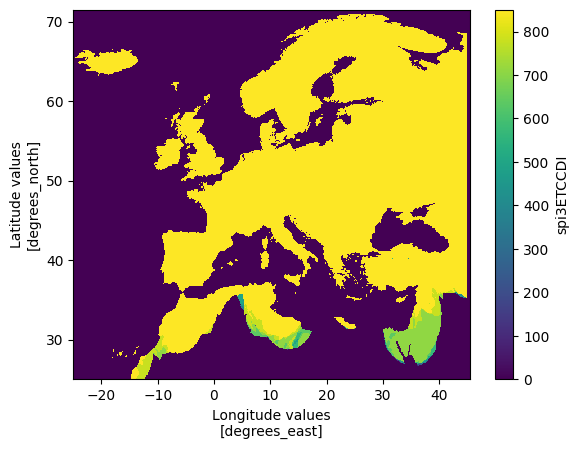

In [142]:
spimon.count('time').plot()

### WP3 investigation

In [223]:
window = 30
wsd = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/1979_2021_monthly_water_surplus_deficit.zarr/')[f'spei_{window}']
lsmask = xr.open_dataarray('/scistor/ivm/jsn295/Medi/landseamask_wp3.nc')

In [224]:
yearround_trend = compute_trends(wsd).compute()
monthly_trend = {}
for month in np.unique(wsd.time.dt.month):
    subset = wsd.isel(time = (wsd.time.dt.month == month))
    monthly_trend.update({month:compute_trends(subset, standardize=True).compute()})
monthly_trend = xr.Dataset(monthly_trend)
#xr.where(lsmask, wsd[0,:,:],np.nan).plot()

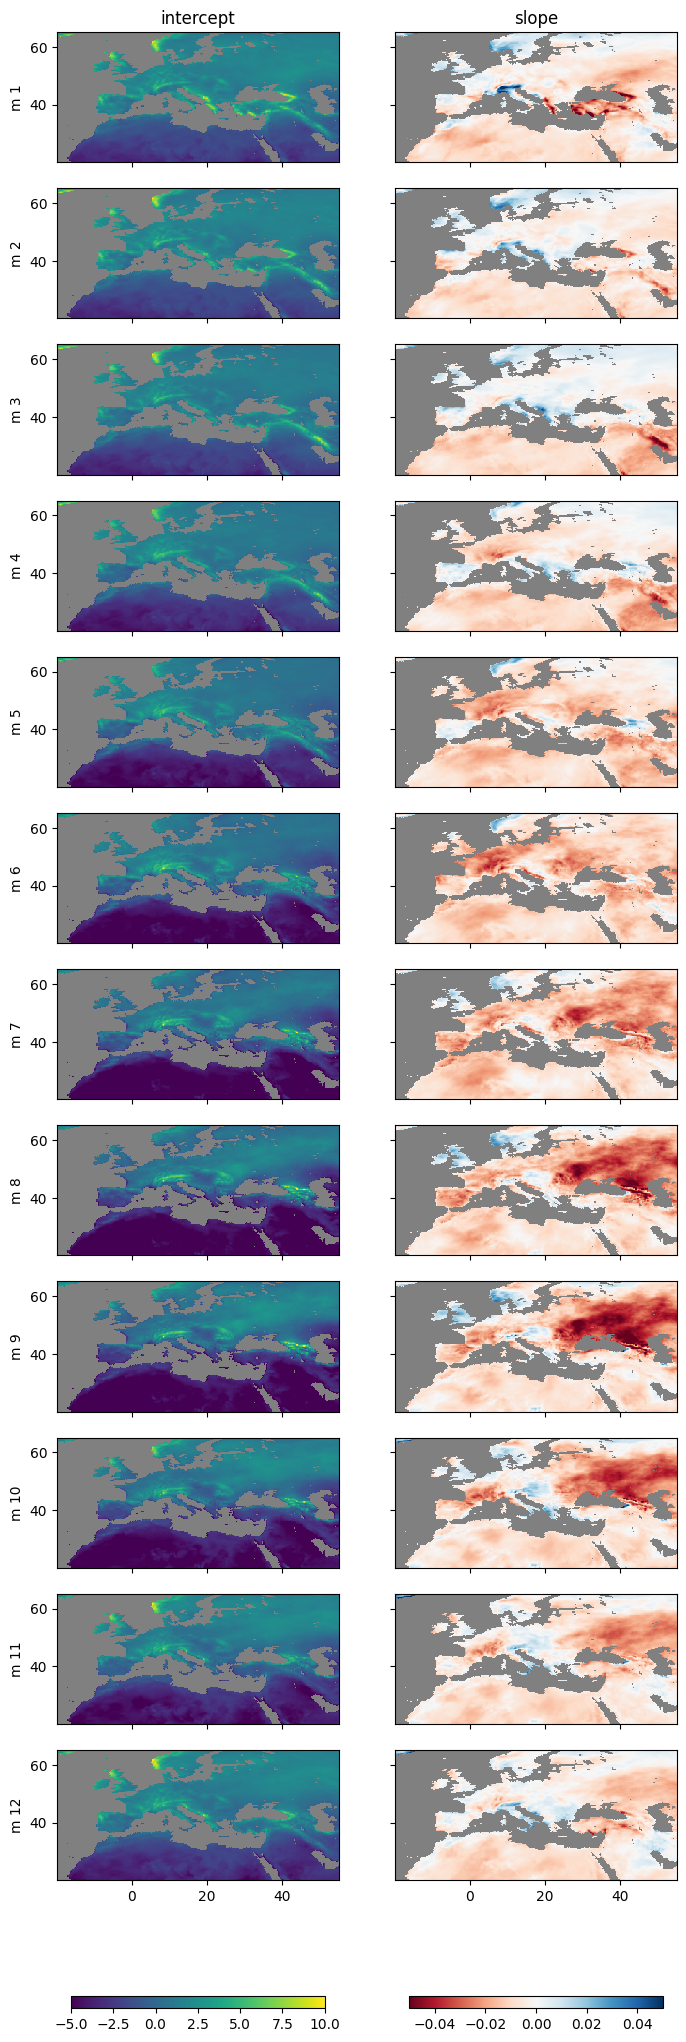

In [177]:
vmin, vmax = -.05, .05
ivmin, ivmax = -5, 10
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 12, ncols = 2, sharex = True, sharey = True, figsize = (8,30))
for i, month in enumerate(np.unique(rrmon.time.dt.month)):
    for j, what in enumerate(yearround_trend.coords['what'].values):
        ax = axes[i,j]
        ax.set_facecolor('grey')
        data = xr.where(lsmask, monthly_trend[month].sel(what = what), np.nan) # Landsea masking
        if i == 0:
            ax.set_title(what)
        if j == 0:
            ax.set_ylabel(f'm {month}')
            imi = ax.pcolormesh(*data_for_pcolormesh(data, shading = 'flat'), vmin = ivmin, vmax = ivmax)
        else:
            ims = ax.pcolormesh(*data_for_pcolormesh(data, shading = 'flat'), cmap = cmap, vmin = vmin, vmax = vmax)
            
cbari = fig.colorbar(imi, ax = axes[:,0], orientation = 'horizontal', pad = 0.05, shrink = 0.9)
cbars = fig.colorbar(ims, ax = axes[:,1], orientation = 'horizontal', pad = 0.05, shrink = 0.9)

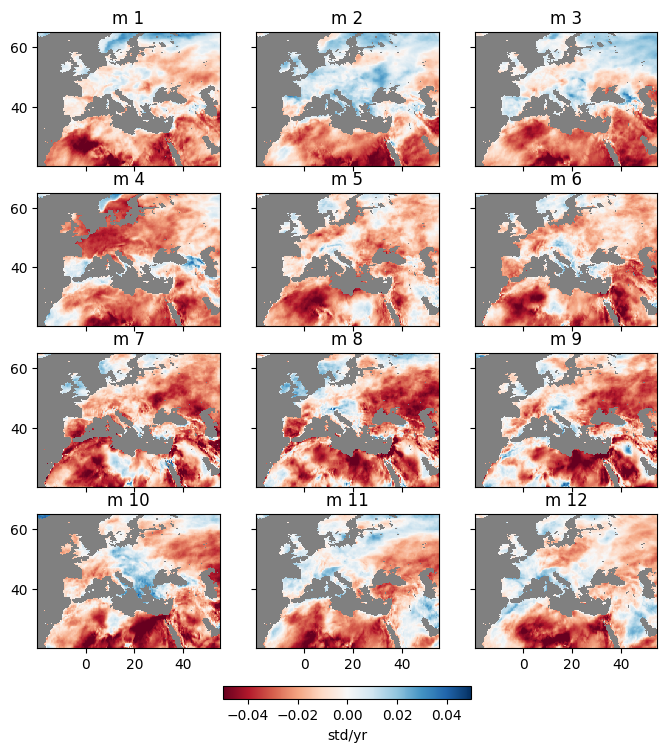

In [231]:
vmin, vmax = -.05, .05
cmap = 'RdBu'
fig, axes = plt.subplots(nrows = 4, ncols = 3, sharex = True, sharey = True, figsize = (8,10))
for i, month in enumerate(np.unique(rrmon.time.dt.month)):
    #print(i//3,i%3)
    ax = axes[i//3,i%3]
    ax.set_facecolor('grey')
    data = xr.where(lsmask, monthly_trend[month].sel(what = 'slope'), np.nan) # Landsea masking
    ax.set_title(f'm {month}')
    im = ax.pcolormesh(*data_for_pcolormesh(data, shading = 'flat'), cmap = cmap, vmin = vmin, vmax = vmax)
            
cbar = fig.colorbar(im, ax = axes, orientation = 'horizontal', pad = 0.05, shrink = 0.4)
cbar.set_label(monthly_trend[month].units)

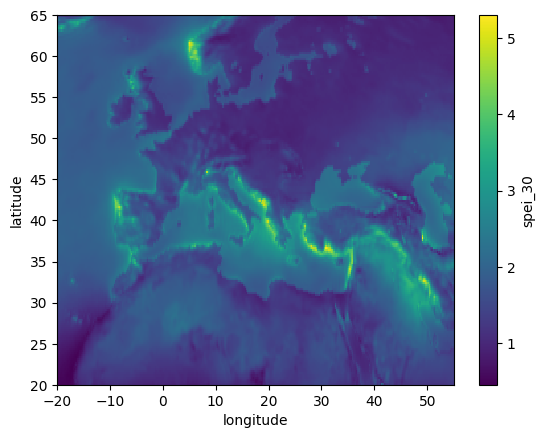

In [235]:
wsd.std('time').compute().plot()

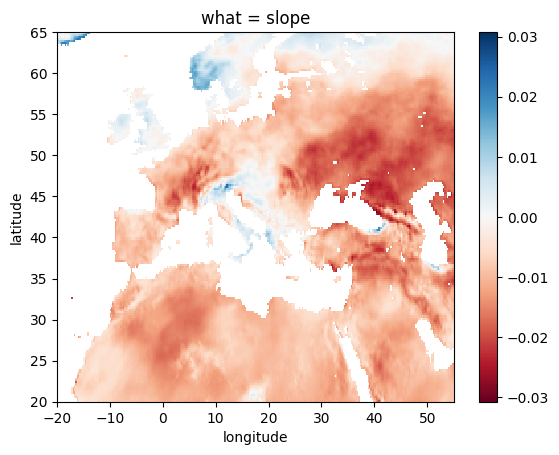

In [181]:
xr.where(lsmask,yearround_trend.sel(what = 'slope'), np.nan).plot(cmap = 'RdBu')

Plotting regions where the sign changes. Or plotting trend relative to standard deviation?

## U-wind climatology and trends.
at 250 and 500 hPa.

In [14]:
levels = [250,500]
ds = xr.Dataset()
for name, (lonmin, lonmax) in udomains.items():
    arrays = []
    for level in levels:
        da = xr.open_dataarray((datapath / f'monthly_zonalmean_u{level}_NH_{lonmin}E_{lonmax}E.nc'))
        da.coords['level'] = level
        arrays.append(da)
    ds.update({name:xr.concat(arrays,dim = 'level')})

In [32]:
seas_clim = ds.groupby(ds.time.dt.month).mean()

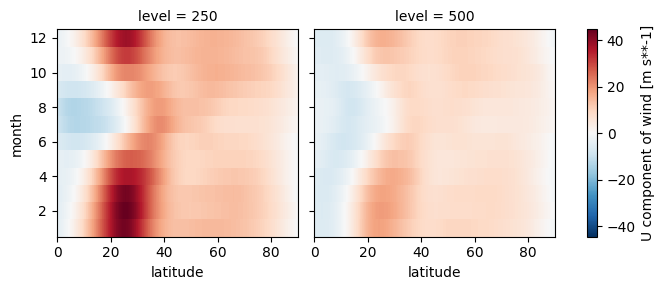

In [33]:
seas_clim['med'].plot(col = 'level')

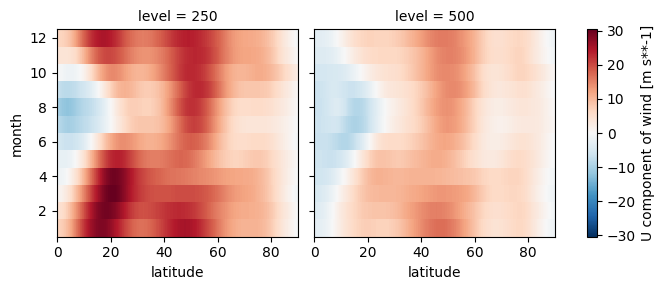

In [34]:
seas_clim['atl'].plot(col = 'level')

This double signal at 250, pleads for using 500 to detect eddy-driven jet over atlantic, cleaner tracing of the maximum. At 250 the atlantic is jumpy:

In [46]:
latmax = ds.idxmax('latitude')

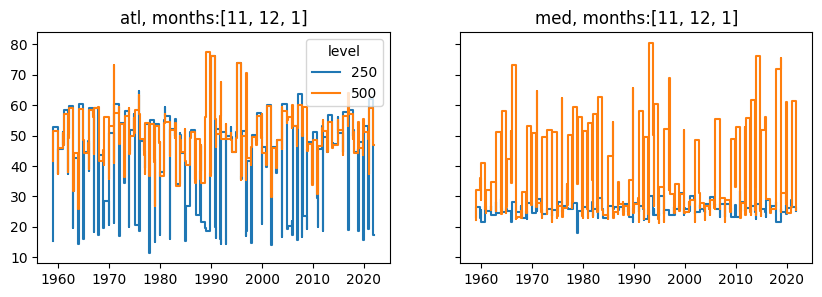

In [73]:
months = [11,12,1] # [12,1,2] DJF
fig, axes = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (10,3))
for i, name in enumerate(['atl','med']):
    ax = axes[i]
    data = latmax[name].isel(time = [m in months for m in latmax.time.dt.month])
    for level in [250,500]:
        ax.step(data.time, data.sel(level = level).values, label = level)
    ax.set_title(f'{name}, months:{months}')
axes[0].legend(title = 'level')

No big northward trend for the subtropical jet in the mediterranean at 250, at least not for the maximum. Also variability is lower than for the eddy driven jet.
#### Trends in speed

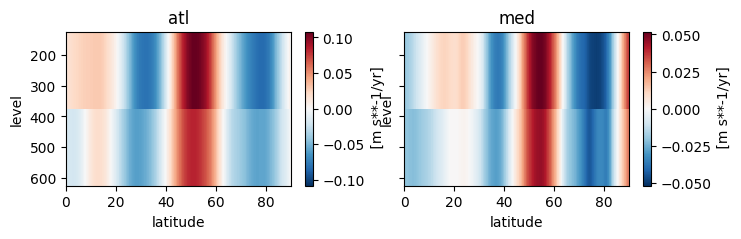

In [99]:
#vmin, vmax = -0.05, 0.05
season = "DJF"
slopes = {name:compute_trends(ds[name].sel(time = ds.time.dt.season == season)).sel(what = 'slope') for name in ['atl','med']}
#atlslope = compute_trends(ds['atl'])
fig, axes = plt.subplots(ncols = 2, figsize = (8,2), sharex = True, sharey= True)
for i, name in enumerate(['atl','med']):
    ax = axes[i]
    slopes[name].plot(ax = ax, cmap = 'RdBu_r')
    ax.set_title(name)
    ax.invert_yaxis()

If sub-tropical jet and eddy driven jet are both strengthening, they should at least be anti-correlated in terms of year-to-year variability, according to Aarnouts theory.

More of a barotropic trend in the atlantic. Some strengthening of subtropical jet at 250. Is it a northward movement? Trend at midlat is highest but windspeeds will actually be lower there.